In [1]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline

# Load data

In [2]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=localhost\SQLEXPRESS01;'
                      'Database=GameDataDb;'
                      'Trusted_Connection=yes;')

In [4]:
DAU_query = "SELECT u.Date, COUNT(DISTINCT u.Id) UniqueUsers FROM [GameDataDb].[dbo].[Users] u GROUP BY u.Date ORDER BY u.Date"
DAU = pd.read_sql_query(DAU_query, conn)
DAU.head()

,Date,UniqueUsers
0,2018-01-01 00:00:00.0000000,11545
1,2018-01-02 00:00:00.0000000,15658
2,2018-01-03 00:00:00.0000000,17881
3,2018-01-04 00:00:00.0000000,19530
4,2018-01-05 00:00:00.0000000,20092


In [7]:
MAU_query = "SELECT CAST(YEAR(u.Date) AS VARCHAR(4)) Year, CAST(MONTH(u.Date) AS VARCHAR(2)) Month, COUNT(DISTINCT u.Id) UniqueUsers FROM [GameDataDb].[dbo].[Users] u GROUP BY CAST(YEAR(u.Date) AS VARCHAR(4)), CAST(MONTH(u.Date) AS VARCHAR(2))"
MAU = pd.read_sql_query(MAU_query, conn)
MAU.head()

,Year,Month,UniqueUsers
0,2018,1,651084


In [9]:
revenue_query = "SELECT cb.Date, SUM(cb.Price) TotalUSDIncome FROM [GameDataDb].[dbo].[CUrrencyBuy] cb GROUP BY cb.Date order by cb.Date"
revenue = pd.read_sql_query(revenue_query, conn)
revenue.head()

,Date,TotalUSDIncome
0,2018-01-01 00:00:00.0000000,5201.0
1,2018-01-02 00:00:00.0000000,9696.0
2,2018-01-03 00:00:00.0000000,15259.0
3,2018-01-04 00:00:00.0000000,20966.0
4,2018-01-05 00:00:00.0000000,27059.0


In [10]:
item_stats_query = "SELECT ib.Item, count(ib.Id) TotalPurchased, sum(ib.Price) TotalInGamePrice, sum(ib.Price) * (select sum(cb.Price) / sum(cb.Income) CurrencyRate FROM [GameDataDb].[dbo].[CurrencyBuy] cb) TotalPriceInUSD FROM [GameDataDb].[dbo].[ItemBuy] ib group by ib.Item order by ib.Item"

In [136]:
item_stats = pd.read_sql_query(item_stats_query, conn)
item_stats.head()

,Item,TotalPurchased,TotalInGamePrice,TotalPriceInUSD
0,A Pony,7277,1164320.0,100908.799043
1,Anarchist Cookbook,50825,508250.0,44048.798538
2,Best Friend,6107,3969550.0,344031.300020
3,Black Hole,6282,3203820.0,277667.332476
4,Blank Card,6792,1630080.0,141275.092022


In [137]:
items_sold_query = "SELECT ib.Date, COUNT(DISTINCT ib.Id) TotalSold FROM [GameDataDb].[dbo].[ItemBuy] ib group by ib.Date order by ib.Date"
items_sold = pd.read_sql_query(items_sold_query, conn)
items_sold.head()

,Date,TotalSold
0,2018-01-01 00:00:00.0000000,1545
1,2018-01-02 00:00:00.0000000,3176
2,2018-01-03 00:00:00.0000000,5029
3,2018-01-04 00:00:00.0000000,7076
4,2018-01-05 00:00:00.0000000,9059


# Linear Regression

In [69]:
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

In [66]:
last_day = DAU.Date.max()
last_day = datetime.strptime(last_day,'%Y-%m-%d %H:%M:%S.%f0')
last_day

datetime.datetime(2018, 1, 30, 0, 0)

In [80]:
next_half_of_the_year = [(last_day + timedelta(days=x)).timestamp() for x in range(1, 180)]
next_half_of_the_year = pd.DataFrame({'date': next_half_of_the_year})
next_half_of_the_year.head()

,date
0,1.517350e+09
1,1.517436e+09
2,1.517522e+09
3,1.517609e+09
4,1.517695e+09


In [81]:
dau_lin = LinearRegression()

In [82]:
def parse_time(time):
    return datetime.strptime(time,'%Y-%m-%d %H:%M:%S.%f0').timestamp()

In [84]:
pd.DataFrame({'date': DAU.Date.map(parse_time).values}).head()

,date
0,1.514758e+09
1,1.514844e+09
2,1.514930e+09
3,1.515017e+09
4,1.515103e+09


In [86]:
dau_lin.fit(pd.DataFrame({'date': DAU.Date.map(parse_time).values}), DAU.UniqueUsers)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [89]:
dau_predictions = dau_lin.predict(next_half_of_the_year)

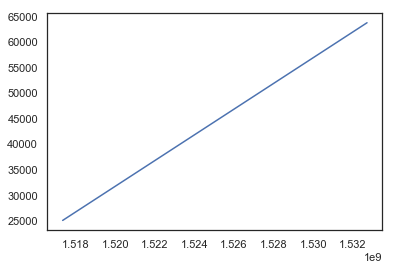

In [104]:
plt.plot((next_half_of_the_year),dau_predictions)

In [105]:
new_users_query = "SELECT u.Date, COUNT(DISTINCT u.Id) NewUsers FROM [GameDataDb].[dbo].[Users] u GROUP BY u.Date order by u.Date"
new_users = pd.read_sql_query(new_users_query, conn)
new_users.head()

,Date,NewUsers
0,2018-01-01 00:00:00.0000000,11545
1,2018-01-02 00:00:00.0000000,15658
2,2018-01-03 00:00:00.0000000,17881
3,2018-01-04 00:00:00.0000000,19530
4,2018-01-05 00:00:00.0000000,20092


In [106]:
lin = LinearRegression()

In [108]:
lin.fit(pd.DataFrame({'date': new_users.Date.map(parse_time).values}), new_users.NewUsers)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [109]:
new_users_pred = lin.predict(next_half_of_the_year)

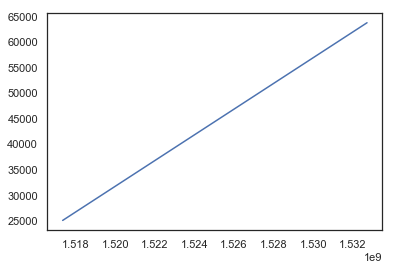

In [110]:
plt.plot((next_half_of_the_year),new_users_pred)

In [111]:
lin.fit(pd.DataFrame({'date': revenue.Date.map(parse_time).values}), revenue.TotalUSDIncome)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

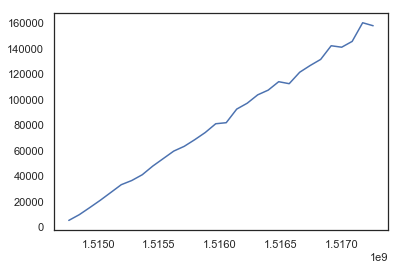

In [112]:
plt.plot(pd.DataFrame({'date': revenue.Date.map(parse_time).values}), revenue.TotalUSDIncome)

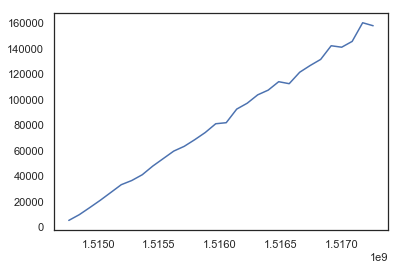

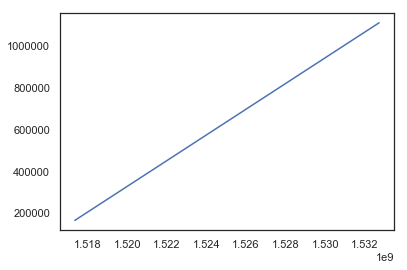

In [132]:
def predict_with_linear_regression(df, X):
    plt.figure()
    plt.plot(pd.DataFrame({'date': df.Date.map(parse_time).values}), df[X])
    lin = LinearRegression()
    lin.fit(pd.DataFrame({'date': df.Date.map(parse_time).values}), df[X])
    pred = lin.predict(next_half_of_the_year)
    plt.figure()

    plt.plot(next_half_of_the_year, pred)


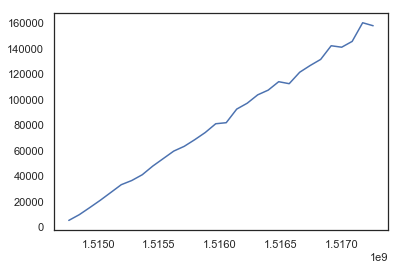

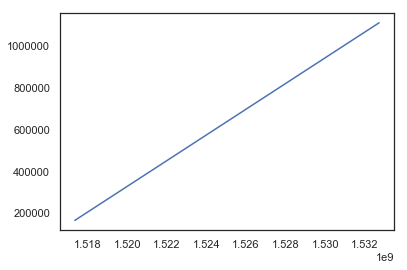

In [133]:
predict_with_linear_regression(revenue, 'TotalUSDIncome')

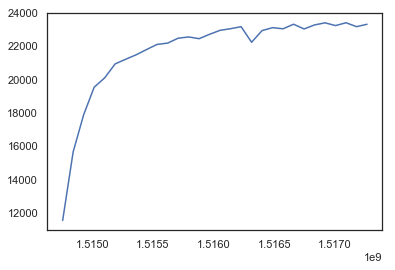

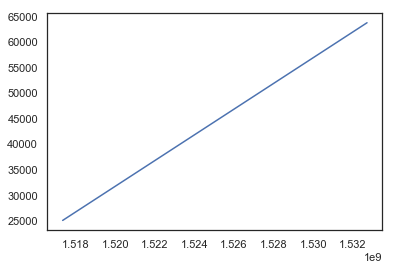

In [134]:
predict_with_linear_regression(DAU, 'UniqueUsers')

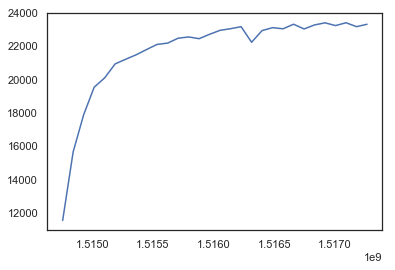

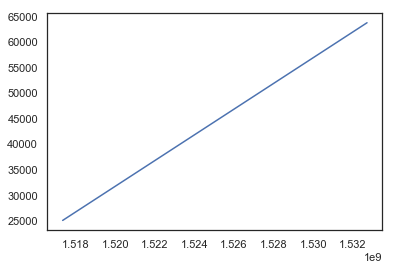

In [135]:
predict_with_linear_regression(new_users, 'NewUsers')

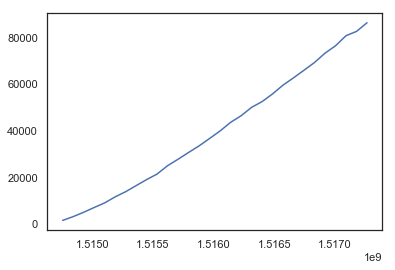

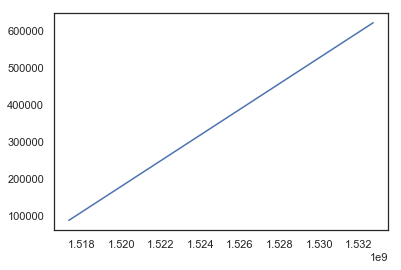

In [138]:
predict_with_linear_regression(items_sold, 'TotalSold')